In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import lib.snn as snn
import lib.spikeFileIO as io
import zipfile
import os
from lib.datasets.mnistdataset import SMNIST
from IPython.display import HTML



In [2]:
# CONSTANTS

USE_CUDA = torch.cuda.is_available()
#


In [3]:
netParams = snn.params('network_specs/slayer_snn.yaml')
print(netParams)

In [4]:

# Network definition
class Network(torch.nn.Module):
    def __init__(self, netParams):
        super(Network, self).__init__()
        # initialize slayer
        slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        # define network functions
        self.conv1 = slayer.conv(1, 12, 5, padding=1)
        self.conv2 = slayer.conv(12, 64, 5, padding=1)
        self.pool1 = slayer.pool(2)
        self.pool2 = slayer.pool(2)
        self.fc1   = slayer.dense((6* 6 * 64), 10)

    def forward(self, spikeInput):
        spikeLayer1 = self.slayer.spike(self.conv1(self.slayer.psp(spikeInput ))) # 32, 32, 16
        spikeLayer2 = self.slayer.spike(self.pool1(self.slayer.psp(spikeLayer1))) # 16, 16, 16
        spikeLayer3 = self.slayer.spike(self.conv2(self.slayer.psp(spikeLayer2))) # 16, 16, 32
        spikeLayer4 = self.slayer.spike(self.pool2(self.slayer.psp(spikeLayer3))) #  8,  8, 32
        spikeLayer4 = spikeLayer4.reshape((-1, 6* 6 * 64, 1, 1, spikeLayer4.shape[-1]))
        spikeOut    = self.slayer.spike(self.fc1  (self.slayer.psp(spikeLayer4))) #  10

        return spikeOut

# class Network(torch.nn.Module):
#     def __init__(self, netParams):
#         super(Network, self).__init__()
#         # initialize slayer
#         slayer = snn.layer(netParams['neuron'], netParams['simulation'])
#         self.slayer = slayer
#         # define network functions
#         # self.conv1 = slayer.conv(1, 16, 5, padding=1)
#         # self.conv2 = slayer.conv(16, 32, 3, padding=1)
#         # self.conv3 = slayer.conv(32, 64, 3, padding=1)
#         # self.pool1 = slayer.pool(2)
#         # self.pool2 = slayer.pool(2)
#         self.fc1   = slayer.dense((28, 28, 1), 512)
#         # self.fc1 = slayer.dense((34 * 34 * 2), 512)
#         self.fc2 = slayer.dense(512, 10)

#     def forward(self, spikeInput):
#         spikeLayer1 = self.slayer.spike(self.slayer.psp(self.fc1(spikeInput)))
#         spikeLayer2 = self.slayer.spike(self.slayer.psp(self.fc2(spikeLayer1)))

#         return spikeLayer2
#         # spikeLayer1 = self.slayer.spike(self.conv1(self.slayer.psp(spikeInput ))) # 32, 32, 16
#         # spikeLayer2 = self.slayer.spike(self.pool1(self.slayer.psp(spikeLayer1))) # 16, 16, 16
#         # spikeLayer3 = self.slayer.spike(self.conv2(self.slayer.psp(spikeLayer2))) # 16, 16, 32
#         # spikeLayer4 = self.slayer.spike(self.pool2(self.slayer.psp(spikeLayer3))) #  8,  8, 32
#         # spikeLayer5 = self.slayer.spike(self.conv3(self.slayer.psp(spikeLayer4))) #  8,  8, 64
#         # spikeOut    = self.slayer.spike(self.fc1  (self.slayer.psp(spikeLayer5))) #  10
#         #
#         # return spikeOut

In [5]:
def save_model(name, model):
    print("Saving models...")
    model.eval()

    save_model_filename = 'saved_models/' + name + '.pt'

    torch.save(model.state_dict(), save_model_filename)
    
def load_model(name, model):
    model.load_state_dict(torch.load('saved_models/' + name + '.pt'))
    
def load_dict(name):
    return torch.load('saved_models/' + name + '.pt')

In [6]:
# INITIALIZATION 


device = torch.device("cuda" if USE_CUDA else "cpu")

#Create network instance.
net = Network(netParams).to(device)

# Create snn loss instance.
error = snn.loss(netParams).to(device)

# Define optimizer module.
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)

# Dataset and dataLoader instances.
trainingSet = SMNIST(datasetPath =netParams['training']['path']['in'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'],
                    train=True)
trainLoader = DataLoader(dataset=trainingSet, batch_size=8, shuffle=False, num_workers=4)

testingSet = SMNIST(datasetPath  =netParams['training']['path']['in'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'],
                    train=False)
testLoader = DataLoader(dataset=testingSet, batch_size=2, shuffle=False, num_workers=4)

# Learning stats instance.
stats = snn.learningStats()

In [7]:
## VISUALIZATION

input, target, label = trainingSet[0]
anim = io.animTD(io.spikeArrayToEvent(input.reshape((1, 28, 28, -1)).cpu().data.numpy()))
HTML(anim.to_jshtml())



In [8]:
## Training

# training loop
Nepochs = 100
for epoch in range(Nepochs):
    # Reset training stats.
    stats.training.reset()
    tSt = datetime.now()
    
    # Training loop.
    for i, (input, target, label) in enumerate(trainLoader, 0):
        # Move the input and target to correct GPU.
        input = input.to(device)
        target = target.to(device)

        # Forward pass of the network.
        output = net.forward(input)

        # Gather the training stats.
        stats.training.correctSamples += torch.sum(snn.predict.getClass(output) == label).data.item()
        stats.training.numSamples += len(label)

        # Calculate loss.
        loss = error.numSpikes(output, target)

        # Reset gradients to zero.
        optimizer.zero_grad()

        # Backward pass of the network.
        loss.backward()

        # Update weights.
        optimizer.step()

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()
        
        # print("SRMkernel: {}".format(net.state_dict()['slayer.srmKernel']))
        # print("Refkernel: {}".format(net.state_dict()['slayer.refKernel']))

        # Display training stats.
        # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
    # Update training stats.
    stats.training.update()
    # Reset testing stats.
    stats.testing.reset()
    # Testing loop.
    # Same steps as Training loops except loss backpropagation and weight update.
    for i, (input, target, label) in enumerate(testLoader, 0):
        input = input.to(device)
        target = target.to(device)

        output = net.forward(input)

        stats.testing.correctSamples += torch.sum(snn.predict.getClass(output) == label).data.item()
        stats.testing.numSamples += len(label)

        loss = error.numSpikes(output, target)
        stats.testing.lossSum += loss.cpu().data.item()
        
        # if i%10 == 0: stats.print(epoch, i)


    # Update stats.
    stats.testing.update()
    if epoch%10==0 or epoch == Nepochs-1: stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())

save_model("SNN", net)


Epoch :          0,    5546.3940 ms elapsed
loss = 11.611       (min = 11.611      )  	accuracy = 0.224      (max = 0.224     )
loss = 11.927       (min = 11.927      )  	accuracy = 0.23       (max = 0.23      )

Epoch :         10,    5524.6550 ms elapsed
loss = 1.1063       (min = 1.1063      )  	accuracy = 0.926      (max = 0.926     )
loss = 1.6317       (min = 1.6317      )  	accuracy = 0.838      (max = 0.838     )

Epoch :         20,    5297.7720 ms elapsed
loss = 0.65596      (min = 0.63744     )  	accuracy = 0.962      (max = 0.964     )
loss = 1.4134       (min = 1.3378      )  	accuracy = 0.85       (max = 0.856     )

Epoch :         30,    5306.0420 ms elapsed
loss = 0.51448      (min = 0.42968     )  	accuracy = 0.974      (max = 0.986     )
loss = 1.2223       (min = 1.1059      )  	accuracy = 0.858      (max = 0.89      )

Epoch :         40,    5629.4150 ms elapsed
loss = 0.40648      (min = 0.40648     )  	accuracy = 0.98       (max = 0.986     )
loss = 1.0201      

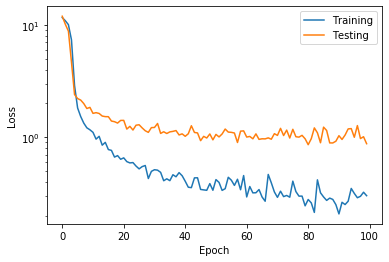

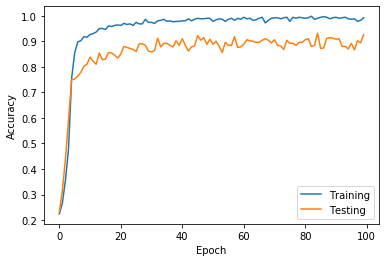

In [9]:
# Plot the results.
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing.lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing.accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [10]:
for k in iter(net.state_dict()):
    print("Layer {}".format(k))
    print(net.state_dict()[k].shape)

Layer slayer.srmKernel
torch.Size([25])
Layer slayer.refKernel
torch.Size([10])
Layer conv1.weight
torch.Size([12, 1, 5, 5, 1])
Layer conv2.weight
torch.Size([64, 12, 5, 5, 1])
Layer pool1.weight
torch.Size([1, 1, 2, 2, 1])
Layer pool2.weight
torch.Size([1, 1, 2, 2, 1])
Layer fc1.weight
torch.Size([10, 2304, 1, 1, 1])


In [11]:
print(net.state_dict()['pool1.weight'])

tensor([[[[[3.1900],
           [3.1900]],

          [[3.1900],
           [3.1900]]]]], device='cuda:0')


# Loading model tailored CNN

In [35]:
netParams2 = snn.params('network_specs/slayer_trailored_cnn.yaml')


In [36]:
# Test loading of the model 
device = torch.device("cuda" if USE_CUDA else "cpu")

#Create network instance.
net2 = Network(netParams2).to(device)

load_model("SNN", net2)

In [37]:
def test_acc(dataloader , model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels =  data[0].to(device), data[2]
            outputs = model.forward(images)
            predicted = snn.predict.getClass(outputs)
            total += len(labels)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network: %1.2f %%' % (100 * correct / total))

In [38]:
test_acc(testLoader, net2)

Accuracy of the network: 91.60 %


In [39]:
tailor_cnn_weights = load_dict("tailor_cnn")
snn_weights = net2.state_dict()

In [40]:
for k in iter(tailor_cnn_weights):
    print("Layer {}".format(k))
    print(tailor_cnn_weights[k].shape)
    if k.startswith('conv') or k.startswith('fc'):
        snn_weights[k] = tailor_cnn_weights[k].reshape(snn_weights[k].shape)

Layer conv1.weight
torch.Size([12, 1, 5, 5])
Layer conv2.weight
torch.Size([64, 12, 5, 5])
Layer fc1.weight
torch.Size([10, 2304])


In [41]:
net2.load_state_dict(snn_weights)

<All keys matched successfully>

In [43]:
test_acc(testLoader, net2)

Accuracy of the network: 26.40 %


In [44]:
# for k in iter(net.state_dict()):
#     print("Layer {}".format(k))
#     if k.startswith('conv') or k.startswith('fc'):
#         print("A:  ", net.state_dict()[k])
#         print("B: ", tailor_cnn_weights[k].reshape(snn_weights[k].shape))
#         break


In [45]:
save_model('snn_slayer', net)

Saving models...


In [46]:
save_model('snn_tailored', net2)

Saving models...
